# Tutorial V: Transfer Learning

<p>
Bern Winter School on Machine Learning, 2024<br>
Prepared by Mykhailo Vladymyrov and Matthew Vowels.
</p>

This work is licensed under a <a href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

In this session we will use the pretrained Inception model to build own image classifier. We will aslo learn how to save our trained models.

## 1. Load necessary libraries

In [ ]:
colab = True # set to True is using google colab

In [101]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" 

import sys
import shutil
import tarfile

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.hub import download_url_to_file
from torchvision import transforms, datasets
from torch.utils.tensorboard import SummaryWriter

from sklearn.model_selection import train_test_split
from PIL import Image

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [162]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Download libraries

In [2]:
if colab:
    path = os.path.join(os.path.abspath('.')+'material.tgz')
    url = 'https://github.com/neworldemancer/BMLWS/raw/main/tut_files/tpub0320.tgz'
    # p = tf.keras.utils.get_file(path, url)
    # Download compressed file with torch utils
    
    download_url_to_file(url=url, dst=path)
    
    tar = tarfile.open(path, "r:gz")
    tar.extractall()
    tar.close()

100%|██████████| 77.4M/77.4M [00:40<00:00, 1.99MB/s]


## 2. Transfer learning

We load first an inception model with pretrained weights, without the final classifier:

In [3]:
print(torch.hub.help('pytorch/vision:v0.7.0', 'inception_v3'))


    Inception v3 model architecture from
    `Rethinking the Inception Architecture for Computer Vision <http://arxiv.org/abs/1512.00567>`_.

    .. note::
        **Important**: In contrast to the other models the inception_v3 expects tensors with a size of
        N x 3 x 299 x 299, so ensure your images are sized accordingly.

    Args:
        weights (:class:`~torchvision.models.Inception_V3_Weights`, optional): The
            pretrained weights for the model. See
            :class:`~torchvision.models.Inception_V3_Weights` below for
            more details, and possible values. By default, no pre-trained
            weights are used.
        progress (bool, optional): If True, displays a progress bar of the
            download to stderr. Default is True.
        **kwargs: parameters passed to the ``torchvision.models.Inception3``
            base class. Please refer to the `source code
            <https://github.com/pytorch/vision/blob/main/torchvision/models/inception.py>`

Using cache found in C:\Users\newor/.cache\torch\hub\pytorch_vision_v0.7.0


In [164]:
base_model = torch.hub.load('pytorch/vision:v0.7.0', 'inception_v3')

Using cache found in C:\Users\newor/.cache\torch\hub\pytorch_vision_v0.7.0
D:\development\Anaconda\envs\napari_cp2\lib\site-packages\torchvision\models\inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


In [5]:
dir(base_model)

['AuxLogits',
 'Conv2d_1a_3x3',
 'Conv2d_2a_3x3',
 'Conv2d_2b_3x3',
 'Conv2d_3b_1x1',
 'Conv2d_4a_3x3',
 'Mixed_5b',
 'Mixed_5c',
 'Mixed_5d',
 'Mixed_6a',
 'Mixed_6b',
 'Mixed_6c',
 'Mixed_6d',
 'Mixed_6e',
 'Mixed_7a',
 'Mixed_7b',
 'Mixed_7c',
 'T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_backward_pre_hooks',
 '_buffers',
 '_call_impl',
 '_compiled_call_impl',
 '_forward',
 '_forward_hooks',
 '_forward_hooks_always_called',
 '_forward_hooks_with_kwargs',
 '_forward_pre_hooks',
 '_forward_pre_hooks_with_kwargs',
 '_get_backward_hooks

In [6]:
base_model

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [21]:
writer = SummaryWriter('runs/inspect_inception_v3')
xs = torch.zeros(1, 3, 299, 299)
writer.add_graph(base_model, xs)
writer.close()

In [22]:
%tensorboard --logdir=runs/inspect_inception_v3

Launching TensorBoard...

And build a new model using it:

In [7]:
def fc_head(in_features, n_classes):
    return nn.Sequential(
        nn.Linear(in_features, 64),
        nn.Sigmoid(),
        nn.Linear(64, n_classes)
    )

In [165]:
# freeze the parameters of the base model
for param in base_model.parameters():
    param.requires_grad = False

# replace existing fc layer with our 2-layer classication head
in_features = base_model.fc.in_features
n_classes = 2
base_model.fc = fc_head(in_features, n_classes)
model = base_model.to(device)

In [166]:
# Loss function
criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [157]:
def get_predictions(logits):
    # no need to apply softmax, as softmax is a monotonic function
    # probs = F.softmax(logits, dim=1)
    _, predictions = torch.max(logits, dim=1)
    return predictions

In [158]:
def calculate_accuracy_batch(predictions, labels):
    n_correct = torch.sum(predictions == labels).item()
    n_total = len(labels)
    return n_correct, n_total

## 3. Dataset

The Inception network is trained on natural images: thigs we see around everyday, like sky, flowers, animals, building, cars.
It builds an hierarchy of features, to describe what it sees. 
This features can be used to train fast on different classes of objects. E.g. [here](https://www.tensorflow.org/tutorials/image_retraining) are more examples on transfer learning.

Here you will see that these features can be even used to detect thngs very different from natural images. Namely we will try to use it to distinguish German text from Italian. We will use 100 samples, taken from 5 German and 5 Italian books, 10 samples each.

In [168]:
# load images from the ML3 folder into torch dataset

image_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder('ML3', transform=image_transform)

In [126]:
text_label = dataset.classes
print(text_label)

['de', 'it']


0 torch.Size([3, 299, 299]) tensor(-2.0837) tensor(2.6400) tensor(1.7154) tensor(1.2477)


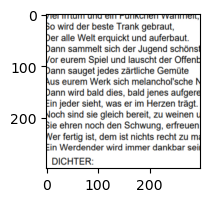

In [136]:
for im, lbl in dataset:
    print(lbl, im.shape, im.min(), im.max(), im.mean(), im.std())
    
    # convert tensor to numpy array, transpose from CHW to HWC and scale to range [0, 1]
    im_numpy = im.cpu().numpy().transpose(1,2,0)
    im_numpy -= im_numpy.min(axis=(0,1))
    im_numpy /= im_numpy.max(axis=(0,1))
    
    plt.figure(figsize=(2,2))
    plt.imshow(im_numpy)
    plt.show()
    break

In [128]:
#We will take 80% from each for training and 20 for validation

batch_size=10

dataset_tra, dataset_val = torch.utils.data.random_split(dataset, [0.8, 0.2])

Is this a good way? Why?

In [129]:
lbls = np.array([lbl for _, lbl in dataset_tra])
print(f'n_class_0 = {np.sum(lbls == 0)}, n_class_1 = {np.sum(lbls == 1)}')

n_class_0 = 43, n_class_1 = 37


it's better to have a balanced (strtifed) training and validation sets

In [130]:
n_samples = len(dataset)
lbls = np.array([lbl for _, lbl in dataset])

# obtain indeces of training and validation samples
idx_tra, idx_val = train_test_split(np.arange(len(dataset)), test_size=0.2, stratify=lbls)

dataset_tra = torch.utils.data.Subset(dataset, idx_tra)
dataset_val = torch.utils.data.Subset(dataset, idx_val)

In [131]:
lbls = np.array([lbl for _, lbl in dataset_tra])
print(f'Training dataset: n_class_0 = {np.sum(lbls == 0)}, n_class_1 = {np.sum(lbls == 1)}')

lbls = np.array([lbl for _, lbl in dataset_val])
print(f'Validation dataset: n_class_0 = {np.sum(lbls == 0)}, n_class_1 = {np.sum(lbls == 1)}')

Training dataset: n_class_0 = 40, n_class_1 = 40
Validation dataset: n_class_0 = 10, n_class_1 = 10


In [132]:
# create data loaders
loader_tra = torch.utils.data.DataLoader(dataset_tra, batch_size=batch_size, shuffle=True)
loader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

Lets see a sample:

torch.Size([10, 3, 299, 299]) tensor(-2.1179) tensor(2.6400) tensor(1.8375) tensor(1.1120)


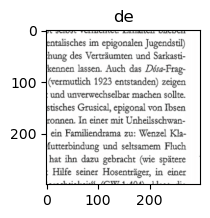

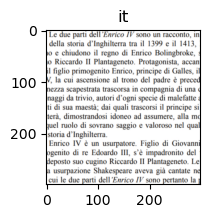

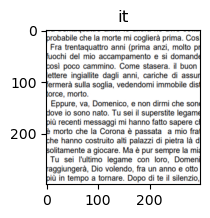

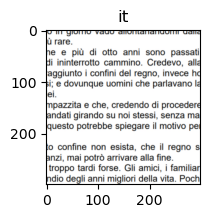

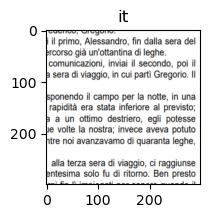

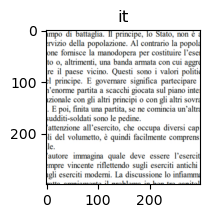

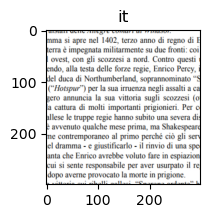

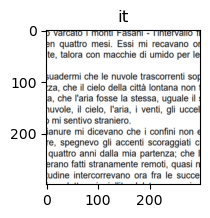

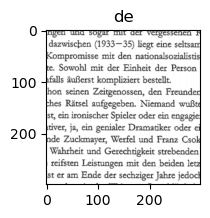

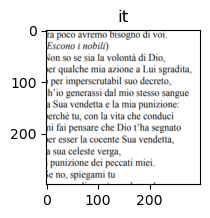

In [135]:
ims, lbls = next(iter(loader_tra))  # get a batch from the training dataset
print(ims.shape, ims.min(), ims.max(), ims.mean(), ims.std())
for im, lbl in zip(ims, lbls):
    # convert tensor to numpy array, transpose from CHW to HWC and scale to range [0, 1]
    im_numpy = im.cpu().numpy().transpose(1,2,0)
    im_numpy -= im_numpy.min(axis=(0,1))
    im_numpy /= im_numpy.max(axis=(0,1))
    
    plt.figure(figsize=(2,2))
    plt.imshow(im_numpy)
    plt.title(text_label[lbl])
    plt.show()

In [174]:
model(ims)

tensor([[ 0.1212, -1.5556],
        [ 0.1903, -1.6302],
        [ 0.1903, -1.6302],
        [ 0.1903, -1.6302],
        [ 0.1739, -1.6125],
        [ 0.1903, -1.6302],
        [ 0.1903, -1.6302],
        [ 0.1899, -1.6297],
        [ 0.1902, -1.6301],
        [ 0.1215, -1.5559]], grad_fn=<AddmmBackward0>)

In [139]:
res = model(ims)

In [140]:
type(res)

torchvision.models.inception.InceptionOutputs

In [148]:
res

InceptionOutputs(logits=tensor([[-0.0696,  0.7773],
        [-0.1554,  0.8122],
        [-0.0094,  0.7418],
        [-0.1467,  0.8070],
        [-0.0730,  0.7634],
        [-0.0504,  0.7283],
        [-0.1063,  0.7062],
        [ 0.0068,  0.7915],
        [-0.0122,  0.7282],
        [-0.0832,  0.7577]], grad_fn=<AddmmBackward0>), aux_logits=tensor([[-0.0508, -0.0357, -0.0356,  ...,  0.0240,  0.0150,  0.0189],
        [-0.0375, -0.0032, -0.0778,  ...,  0.0335,  0.0556,  0.0020],
        [-0.0211,  0.0100, -0.0586,  ..., -0.0068,  0.0297,  0.0045],
        ...,
        [-0.0414,  0.0037, -0.0405,  ...,  0.0254,  0.0514,  0.0166],
        [-0.0581, -0.0467, -0.0518,  ...,  0.0050,  0.0012,  0.0313],
        [ 0.0015, -0.0361, -0.0511,  ...,  0.0396,  0.0155,  0.0109]]))

In [149]:
logits = res.logits
logits.shape

torch.Size([10, 2])

## 4. Training

The training is similar to what we saw previously.

Since Inception model is big, this will take a while, even we use GPUs. On your laptop CPU this would probably take ~15 times longer. And we are not training the whole Inception! We have just small thing on top + a very small dataset!

We will use callback to save checkpoints on each iteration of training. They contain values of trainable variables.

In [187]:
def train(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    n_correct_running = 0
    n_samples_running = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()  # reset gradients
        logits = model(images).logits
        loss = criterion(logits, labels)
        
        
        loss.backward()    # compute gradients
        optimizer.step()   # update parameters with gradients
        
        n_correct, n_samples = calculate_accuracy_batch(get_predictions(logits), labels)
        n_correct_running += n_correct
        n_samples_running += n_samples
        running_loss += loss.item()
        
    n = len(train_loader)
    return running_loss / n, n_correct_running / n_samples_running

def validate(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    n_correct_running = 0
    n_samples_running = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            logits = model(images)  # at the inference the model outputs just the logits
            loss = criterion(logits, labels)
            
            n_correct, n_samples = calculate_accuracy_batch(get_predictions(logits), labels)
            n_correct_running += n_correct
            n_samples_running += n_samples
            running_loss += loss.item()
        
    n = len(val_loader)
    return running_loss / n, n_correct_running / n_samples_running

In [188]:
def train_model(model, criterion, optimizer, n_epochs, train_loader, val_loader, save_path):
    os.makedirs(save_path, exist_ok=True)
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'epoch': []}
    
    for epoch in range(n_epochs):
        train_loss, train_acc = train(model, train_loader, criterion, optimizer)
        val_loss, val_acc = validate(model, val_loader, criterion)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['epoch'].append(epoch)
        
        save_dict = {'epoch': epoch, 
                     'model_state_dict': model.state_dict(), 
                     'optimizer_state_dict': optimizer.state_dict(),
                     'history': history,
                     }
        torch.save(save_dict, os.path.join(save_path, f'model_epoch_{epoch:03d}.pth'))
        
        print(f'Epoch {epoch+1}/{n_epochs} | '
              f'train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f} | '
              f'val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}')
        
    return history

In [189]:
def plot_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(10,5))
    axs[0].plot(history['epoch'], history['train_loss'])
    axs[0].plot(history['epoch'], history['val_loss'])
    axs[0].legend(('training loss', 'validation loss'), loc='lower right')
    
    axs[1].plot(history['epoch'], history['train_acc'])
    axs[1].plot(history['epoch'], history['val_acc'])
    axs[1].legend(('training accuracy', 'validation accuracy'), loc='lower right')
    plt.show() 

In [190]:
save_path = 'TL_1'

n_epochs=150

history = train_model(model, criterion, optimizer, n_epochs, loader_tra, loader_val, save_path)

Epoch 1/150 | train_loss: 0.6562, train_acc: 6.0000 | val_loss: 0.8774, val_acc: 5.0000
Epoch 2/150 | train_loss: 0.6406, train_acc: 6.6250 | val_loss: 0.6917, val_acc: 5.0000
Epoch 3/150 | train_loss: 0.6247, train_acc: 5.8750 | val_loss: 0.6553, val_acc: 5.5000
Epoch 4/150 | train_loss: 0.6141, train_acc: 6.3750 | val_loss: 0.6359, val_acc: 6.0000
Epoch 5/150 | train_loss: 0.5988, train_acc: 6.3750 | val_loss: 0.6130, val_acc: 6.0000
Epoch 6/150 | train_loss: 0.6187, train_acc: 6.2500 | val_loss: 0.5965, val_acc: 7.5000
Epoch 7/150 | train_loss: 0.6582, train_acc: 6.3750 | val_loss: 0.6293, val_acc: 6.0000
Epoch 8/150 | train_loss: 0.6230, train_acc: 6.7500 | val_loss: 0.5789, val_acc: 8.0000
Epoch 9/150 | train_loss: 0.5722, train_acc: 7.0000 | val_loss: 0.5655, val_acc: 6.5000
Epoch 10/150 | train_loss: 0.5950, train_acc: 6.8750 | val_loss: 0.5474, val_acc: 7.5000
Epoch 11/150 | train_loss: 0.5836, train_acc: 6.2500 | val_loss: 0.5775, val_acc: 6.5000
Epoch 12/150 | train_loss: 0.6

KeyboardInterrupt: 

In [191]:
plot_history(history)

NameError: name 'history' is not defined

We see that training accuracy hits 100% quickly. Why do you think it happens? Consider that loss keeps decreasing.
Also on such a small dataset our model overfits.

In [192]:
d = torch.load(os.path.join(save_path, 'model_epoch_011.pth'))
h = d['history']

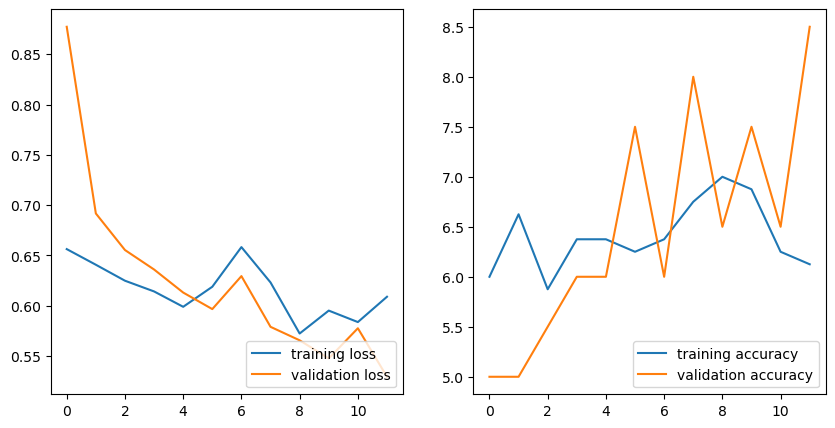

In [193]:
plot_history(h)

## 5. Load trained variables

If we have the model already created we can easily load the saved training variables values from a checkpoint:

In [194]:
test_epochs = [0, 5, 11, 24, 149]
for ep in test_epochs:
    d = torch.load(os.path.join(save_path, f'model_epoch_{ep:03d}.pth'))
    
    model_state_dict = d['model_state_dict']
    model.load_state_dict(model_state_dict)
    
    loss, acc = validate(model, loader_val, criterion)
    print(f'Epoch {ep} | val_loss: {loss:.4f}, val_acc: {acc:.4f}')

Epoch 0 | val_loss: 0.8774, val_acc: 5.0000
Epoch 5 | val_loss: 0.5965, val_acc: 7.5000
Epoch 11 | val_loss: 0.5292, val_acc: 8.5000
Epoch 24 | val_loss: 0.4763, val_acc: 9.0000


FileNotFoundError: [Errno 2] No such file or directory: 'TL_1\\model_epoch_149.pth'

## 6. Saving for inference.

In pytorch it's easy to save a model for inference:

In [195]:
# export the model for inference
torch.save(model, 'inference_model.pth')

## 7. Inference

In [197]:
loaded_model = torch.load('inference_model.pth')
loaded_model = loaded_model.to(device)
loaded_model.eval();  # set the model to inference mode

In [204]:
# get an image:
im = Image.open('ML3/it/1_1.jpg')
# convert to tensor
im_tensor = image_transform(im)
# add batch dimension
im_tensor = im_tensor.unsqueeze(0).to(device)

print(im_tensor.shape)

torch.Size([1, 3, 299, 299])


In [206]:
# get the logits and class
with torch.no_grad():    
    logits = loaded_model(im_tensor)
    probs = F.softmax(logits, dim=1)
    pred = get_predictions(logits)
    
probs = probs.cpu().numpy()[0]  # only one element in the batch
pred = pred.cpu().numpy()[0]
print(probs[pred], text_label[pred])


      

0.66011053 it


Or we can make a nice wrapper:

In [ ]:
inf = Inferer('inference_model', output_name)

In [ ]:
inf.infere(images0)

In [ ]:
images_all = np.concatenate([images0, images1])

In [ ]:
inf.infere(images_all, prob=True) # ouput class confidence probability

## 8. Improving the results

Often, as in this sample we don't have anough labeled data in hand. We need to use it as efficient as possible.
One way to do it is to aply training data augmentation: we can slightly distort it, e.g. rescale, to effectively multiply the dataset.

We will generate rescaled images, minimum - to have smaller dimension equal 256, maximum - 130%. Let's define a function which will do this job:

In [168]:
# load images from the ML3 folder into torch dataset

image_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    
    #transforms.RandomCrop(512, pad_if_needed=True, fill=255),
    #transforms.RandomCrop(299),
    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder('ML3', transform=image_transform)

0 torch.Size([3, 299, 299]) tensor(-2.0837) tensor(2.6400) tensor(1.7154) tensor(1.2477)


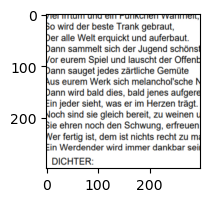

In [136]:
for im, lbl in dataset:
    print(lbl, im.shape, im.min(), im.max(), im.mean(), im.std())
    
    # convert tensor to numpy array, transpose from CHW to HWC and scale to range [0, 1]
    im_numpy = im.cpu().numpy().transpose(1,2,0)
    im_numpy -= im_numpy.min(axis=(0,1))
    im_numpy /= im_numpy.max(axis=(0,1))
    
    plt.figure(figsize=(2,2))
    plt.imshow(im_numpy)
    plt.show()
    break

In [130]:
n_samples = len(dataset)
lbls = np.array([lbl for _, lbl in dataset])

# obtain indeces of training and validation samples
idx_tra, idx_val = train_test_split(np.arange(len(dataset)), test_size=0.2, stratify=lbls)

dataset_tra = torch.utils.data.Subset(dataset, idx_tra)
dataset_val = torch.utils.data.Subset(dataset, idx_val)

In [132]:
# create data loaders
loader_tra = torch.utils.data.DataLoader(dataset_tra, batch_size=batch_size, shuffle=True)
loader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

In [ ]:
base_model = torch.hub.load('pytorch/vision:v0.7.0', 'inception_v3')

# freeze the parameters of the base model
for param in base_model.parameters():
    param.requires_grad = False
    
# replace existing fc layer with our 2-layer classication head
in_features = base_model.fc.in_features
n_classes = 2
base_model.fc = fc_head(in_features, n_classes)
model_aug = base_model.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer = optim.Adam(model_aug.parameters(), lr=0.001)

In [ ]:
save_path = 'TL_2'

n_epochs=200

history = train_model(model_aug, criterion, optimizer, n_epochs, loader_tra, loader_val, save_path)

In [ ]:
plot_history(history)

We had a REEEALLY small dataset for such a complicated task. Does it really generalize? mb it just memorizes all the images we fed into it? Lets perform a test. `w1.PNG` and `w2.PNG` are text screenshots from wikipedia in [Italian](https://it.wikipedia.org/wiki/Apprendimento_automatico) and [German](https://de.wikipedia.org/wiki/Maschinelles_Lernen).

## 9. Exersize 1

In [ ]:
# load images
im_wiki_1 = plt.imread('ML3/w1.jpg')
im_wiki_2 = plt.imread('ML3/w2.jpg')

visualize the samples and perform inference

In [ ]:
...

## 10. Excercises

Do in 4 groups (35 min), in the end present results (2 min/group)

### Option 1.

In the situation when the model is likely to overfit, final performance would especially depend on the training datasets variety.

* Experiment with changes in aspect ratio and scale, using, e.g. 
  `transforms.RandomResizedCrop(299, scale=(0.5, 2.0), ratio=(0.7, 1.3))` instead of the `transforms.RandomCrop`.
* Which other augmentations would make sense for the text data?
* Experiment and compare resulting best validation performance and number of epochs until the best validation accuracy.


### Option 2.

In the situation when the model is likely to overfit, final performance would especially depend on the learning rate.

* Plot the best validation accuracy vs learning rate.
* Plot the number of epochs until the best validation accuracy vs learning rate.

Test learning rates within +/- 1.5 orders of magnitude, i.e. from 30 times smaller to 30 times larger learning rates, than the current one.

Get 3 replicates.

### Option 3.

In the situation when the model is likely to overfit, final performance would especially depend on the model's architecture.

* Plot the best validation accuracy vs width of the first dense layer.
* Plot the number of epochs until the best validation accuracy vs width.

Test number of features in the first dense layer between 8 and 4096.

Get 3 replicates.

### Option 4.

We tested one model for the backbone of transfer learning. Try other ones (at least 3): https://pytorch.org/vision/stable/models.html.


* Plot the best validation accuracy vs model.
* Plot the number of epochs until the best validation accuracy vs model.
* Does any model generalize to wiki data?

Run 3 replicates for each model. Input size might vary for different models, adjust the crop size accordingly in parameters to `prepare_training_img`.

